### Importing the required dependencies

In [1]:
# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Importing other required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# importing required ML libraries
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import catboost
from xgboost import XGBClassifier

# Checking all the columns 
pd.set_option('display.max_columns',None)

### Loading the data

In [2]:
# Filepaths for train and test dataset
train_dataset=r'C:\Users\DELL\playground-series-s4e12\train.csv'
test_dataset=r'C:\Users\DELL\playground-series-s4e12\test.csv'

In [3]:
# Reading the required training & testing data into a pandas dataframe
df_train=pd.read_csv(train_dataset)
df_test=pd.read_csv(test_dataset)

### Metadata Analysis


In [4]:
# Checking the basic data available
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [5]:
# Checking the shape
df_train.shape

(1200000, 21)

In [6]:
# Checking the null values
(100*df_train.isnull().sum()/len(df_train))

id                       0.000000
Age                      1.558750
Gender                   0.000000
Annual Income            3.745750
Marital Status           1.544083
Number of Dependents     9.139333
Education Level          0.000000
Occupation              29.839583
Health Score             6.173000
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
Policy Start Date        0.000000
Customer Feedback        6.485333
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64

In [7]:
# Checking the first five rows
df_train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [8]:
# Extracting the Month & Year, then dropping the Policy Start Date column
def date_time_handler(df:pd.DataFrame):
  df['Policy Start Date']=pd.to_datetime(df['Policy Start Date'])
  df['Month']=df['Policy Start Date'].dt.month.astype('object') # Making Month object data type considering its usecase
  df['Year']=df['Policy Start Date'].dt.year.astype('object') # Making Year object data type considering its usecase
  df.drop(['Policy Start Date'],axis=1,inplace=True)
  return df

In [9]:
# Applying the date time handler function on train and test dataframe
df_train=date_time_handler(df_train)
df_test=date_time_handler(df_test)

In [10]:
# Making a function which will extract the columns which have missing values below certain threshold
def missing_value_col_below_threshold(df:pd.DataFrame,threshold_value:int)->list:
  
  below_threshold_missing_value=[]

  if not isinstance(threshold_value,int):
    raise TypeError(f"The given value for threshold is {threshold_value}, which is not an integer")
  
  if not isinstance(df,pd.DataFrame):
    raise TypeError(f'The given value of the dataframe is not a pandas dataframe')
  
  rqd_result=(100*df.isnull().sum()/len(df))

  for each_col,each_val in rqd_result.items():
    if each_val<=threshold_value and each_val!=0:
      below_threshold_missing_value.append((each_col,each_val,df[each_col].dtype))

  below_threshold_missing_value=sorted(below_threshold_missing_value,key=lambda x:x[1],reverse=True)

  return below_threshold_missing_value


In [11]:
# Checking if train & test data set has similar columns

missing_train=np.array([each_col for each_col,_,_ in missing_value_col_below_threshold(df_train,50)])
missing_test=np.array([each_col for each_col,_,_ in missing_value_col_below_threshold(df_test,50)])

print(missing_train==missing_test)

[ True  True  True  True  True  True  True  True  True  True  True]


In [12]:
# Also checking if the missing values in these columns are close to each other

missing_train_values=np.array([each_val for _,each_val,_ in missing_value_col_below_threshold(df_train,50)])
missing_test_values=np.array([each_val for _,each_val,_ in missing_value_col_below_threshold(df_test,50)])

print(missing_train_values-missing_test_values)

[-0.0145     -0.05104167  0.05879167 -0.00191667 -0.04916667 -0.008125
  0.01325    -0.002375    0.00208333  0.000125   -0.00016667]


In [13]:
# Checking the columns in train data set which have missing values below or equal to 15 %
missing_value_col_below_threshold(df_train,15)

[('Credit Score', 11.490166666666667, dtype('float64')),
 ('Number of Dependents', 9.139333333333333, dtype('float64')),
 ('Customer Feedback', 6.485333333333333, dtype('O')),
 ('Health Score', 6.173, dtype('float64')),
 ('Annual Income', 3.74575, dtype('float64')),
 ('Age', 1.55875, dtype('float64')),
 ('Marital Status', 1.5440833333333333, dtype('O')),
 ('Vehicle Age', 0.0005, dtype('float64')),
 ('Insurance Duration', 8.333333333333333e-05, dtype('float64'))]

In [14]:
# Making a function to extract the values from the missing_value_col_below_threshold function
# Replacing the missing values in respective columns based upon their data types

def replacing_missing_values(df:pd.DataFrame,missing_value_tuple:list[tuple]):
  result=missing_value_tuple
  col_name,_,data_types =zip(*result)

  for col,data_type in zip(col_name,data_types):
    if data_type=='float64':
      df[col]=df[col].fillna(df[col].median())
    elif data_type=='object':
      df[col]=df[col].fillna(df[col].mode()[0])
  
  return df


In [15]:
# Replacing the missing values in the train dataframe by the median or mode if the missing value percentage is less than or equal to 15
col_to_impute=missing_value_col_below_threshold(df_train,15)
df_train=replacing_missing_values(df_train,col_to_impute)

In [16]:
# Checking the missing value columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1200000 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1200000 non-null  float64
 4   Marital Status        1200000 non-null  object 
 5   Number of Dependents  1200000 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1200000 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1200000 non-null  float64
 13  Credit Score          1200000 non-null  float64
 14  Insurance Duration    1200000 non-

In [17]:
# Checking the values in the Previous Claims & Occupation columns
print(df_train['Previous Claims'].unique())
print(df_train.Occupation.unique())

[ 2.  1.  0. nan  3.  4.  5.  6.  7.  8.  9.]
['Self-Employed' nan 'Employed' 'Unemployed']


In [18]:
# Returning the columns which are having higher percentage of missing values
col_with_high_missing_values=missing_value_col_below_threshold(df_train,100)

In [19]:
# Function to convert the Occupation column into a numerical variable so that XGBoost classifier will be able to impute missing values
def occupation_converter(occu:str)->int:
  if occu=="Self-Employed":
    return 0
  elif occu=="Employed":
    return 1
  elif occu=="Unemployed":
    return 2
  elif pd.isnull(occu): # np.Nan is special type of float so need to remove it 
    return -1 # To mark missing values
  else:
    return -1 # to handle unexpected values

In [20]:
# Formulating a function to impute the missing values for columns with high percentage of missing values
def preprocessing_high_missing_value_col(df:pd.DataFrame,list_of_tuples:list[tuple])->pd.DataFrame:
  result=list_of_tuples # Taking the list of tuples which contain the columns with high missing values
  high_missing_col,_,_=zip(*result) # Extracting the columns with high missing values
  
  for each_col in high_missing_col:
    if each_col=="Previous Claims":
      df[each_col]=df[each_col].fillna(-1).astype("int64") # Filling missing values with a placeholder of -1 & changing the datatype for XGBClassifer application
    elif each_col=="Occupation":
      df[each_col]=df[each_col].apply(lambda x:occupation_converter(x))
    else:
      pass

  return df

In [21]:
# Making the train dataset ready for the final missing value imputation
df_train=preprocessing_high_missing_value_col(df_train,col_with_high_missing_values)

### Data preparation for the missing value imputation using XGBoost

In [22]:
# Creating a helper function for the conversion of the object columns in to the category columns

def object_to_category(df:pd.DataFrame)->pd.DataFrame:
  return df.astype({col:'category' for col in df.select_dtypes(include='object').columns})

In [23]:
# Making the suitable datasets
df_prev_claim=df_train.drop(columns=['Occupation','Premium Amount','id'],axis=1)
df_occu=df_train.drop(columns=['Previous Claims','Premium Amount','id'],axis=1)

In [24]:
# Checking the first five rows
df_occu.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Month,Year
0,19.0,Female,10049.0,Married,1.0,Bachelor's,0,22.598761,Urban,Premium,17.0,372.0,5.0,Poor,No,Weekly,House,12,2023
1,39.0,Female,31678.0,Divorced,3.0,Master's,-1,15.569731,Rural,Comprehensive,12.0,694.0,2.0,Average,Yes,Monthly,House,6,2023
2,23.0,Male,25602.0,Divorced,3.0,High School,0,47.177549,Suburban,Premium,14.0,595.0,3.0,Good,Yes,Weekly,House,9,2023
3,21.0,Male,141855.0,Married,2.0,Bachelor's,-1,10.938144,Rural,Basic,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,6,2024
4,21.0,Male,39651.0,Single,1.0,Bachelor's,0,20.376094,Rural,Premium,8.0,598.0,4.0,Poor,Yes,Weekly,House,12,2021


In [25]:
# Extracting the train and test data from occupation columns
df_occu_train=df_occu[df_occu['Occupation']!=-1]
df_occu_test=df_occu[df_occu['Occupation']==-1]

In [26]:
# Extracting the label
y_occu=df_occu_train.pop('Occupation')
X_occu=df_occu_train.copy()

In [27]:
# XGBoost needs all columns to be of numeric type but to handle this with some advanced functionalities, I needed to convert the object columns into categorical columns
X_occu=object_to_category(X_occu)

In [28]:
# Using XGB Classifier
xgb_occu=XGBClassifier(objective='multi:softmax',
                       num_class=y_occu.nunique(),
                       eval_metric='merror',
                       max_depth=5,
                       learning_rate=0.01,
                       n_estimators=100,
                       tree_method='hist',
                       enable_categorical=True)

In [29]:
# Fitting the xgb classifier object on the y_occu & X_occu
xgb_occu.fit(X_occu,y_occu)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='merror', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [30]:
# Dropping the occupation column from the df_occu_test
df_occu_test.drop(['Occupation'],axis=1,inplace=True)

In [31]:
# Before predicitng on the df_occu_test, I need to make sure that the object datatype columns are converted into category datatype
df_occu_test=object_to_category(df_occu_test)

In [32]:
# Predicting the occupation column from the df_occu_test
y_occu_test=xgb_occu.predict(df_occu_test)

In [33]:
# Now adding the y_occu_test directly into the df_train
df_train.loc[df_train['Occupation']==-1,'Occupation']=y_occu_test

In [34]:
# Checking the first 5 rows of df_prev_claim
df_prev_claim.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Month,Year
0,19.0,Female,10049.0,Married,1.0,Bachelor's,22.598761,Urban,Premium,2,17.0,372.0,5.0,Poor,No,Weekly,House,12,2023
1,39.0,Female,31678.0,Divorced,3.0,Master's,15.569731,Rural,Comprehensive,1,12.0,694.0,2.0,Average,Yes,Monthly,House,6,2023
2,23.0,Male,25602.0,Divorced,3.0,High School,47.177549,Suburban,Premium,1,14.0,595.0,3.0,Good,Yes,Weekly,House,9,2023
3,21.0,Male,141855.0,Married,2.0,Bachelor's,10.938144,Rural,Basic,1,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,6,2024
4,21.0,Male,39651.0,Single,1.0,Bachelor's,20.376094,Rural,Premium,0,8.0,598.0,4.0,Poor,Yes,Weekly,House,12,2021


In [35]:
# Extracting the train and the test from previous claims column
df_prev_claim_train=df_prev_claim[df_prev_claim['Previous Claims']!=-1]
df_prev_claim_test=df_prev_claim[df_prev_claim['Previous Claims']==-1]

In [36]:
# Extracting the previous claims labels
y_prev_claim=df_prev_claim_train.pop('Previous Claims')
X_prev_claim=df_prev_claim_train.copy()

In [37]:
# XGBoost needs all columns to be of numeric type but to handle this with some advanced functionalities, I needed to convert the object columns into categorical columns
X_prev_claim=object_to_category(X_prev_claim)

In [38]:
# Using XGB Classifier
xgb_prev_claim=XGBClassifier(objective='multi:softmax',
                             num_class=y_prev_claim.nunique(),
                             eval_metric='merror',
                             max_depth=5,
                             learning_rate=0.01,
                             n_estimators=100,
                             tree_method='hist',
                             enable_categorical=True)

In [39]:
# Fitting XGB Classifier object on X_prev_claim & y_prev_claim
xgb_prev_claim.fit(X_prev_claim,y_prev_claim)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='merror', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)

In [40]:
# Dropping the unnecessary column of previous claims from the df_prev_claim_test
df_prev_claim_test.drop(['Previous Claims'],axis=1,inplace=True)

In [41]:
# Changing the datatype of the object columns to the category for using the XGB Classifier 
df_prev_claim_test=object_to_category(df_prev_claim_test)

In [42]:
# Predicting the y_prev_claims_test
y_prev_claims_test=xgb_prev_claim.predict(df_prev_claim_test)

In [43]:
# Now adding the y_prev_claims_test to df_train
df_train.loc[df_train['Previous Claims']==-1,'Previous Claims']=y_prev_claims_test

In [44]:
# Checking the null values 
df_train.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
Month                   0
Year                    0
dtype: int64

In [45]:
# Checking the unique elements in previous claims and occupation
print(df_train['Occupation'].unique())
print(df_train['Previous Claims'].unique())

[0 1 2]
[2 1 0 3 4 5 6 7 8 9]


In [46]:
# Now that I have got all the values in the Occupation column after missing value imputation, I would rever the effect of occupation_converter 
occupation_mapping={0:"Self-Employed",1:"Employed",2:"Unemployed"}

df_train['Occupation']=df_train['Occupation'].apply(lambda x : occupation_mapping.get(x))

### Starting EDA as the missing value imputation has been completed 

In [47]:
# Checking the info of the df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1200000 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1200000 non-null  float64
 4   Marital Status        1200000 non-null  object 
 5   Number of Dependents  1200000 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            1200000 non-null  object 
 8   Health Score          1200000 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       1200000 non-null  int64  
 12  Vehicle Age           1200000 non-null  float64
 13  Credit Score          1200000 non-null  float64
 14  Insurance Duration    1200000 non-

In [48]:
# Dropping the id column from the df_train
df_train.drop(columns=['id'],axis=1,inplace=True)

In [49]:
# Extracting the numeric columns for plotting the box plots
num_col=set(df_train.select_dtypes(include=['float64','int64']).columns)
high_unique_values=set([col for col,unique_value in df_train.nunique().items() if unique_value>=10])
rqd_num_col=num_col.intersection(high_unique_values)

#### Boxplot of numeric features

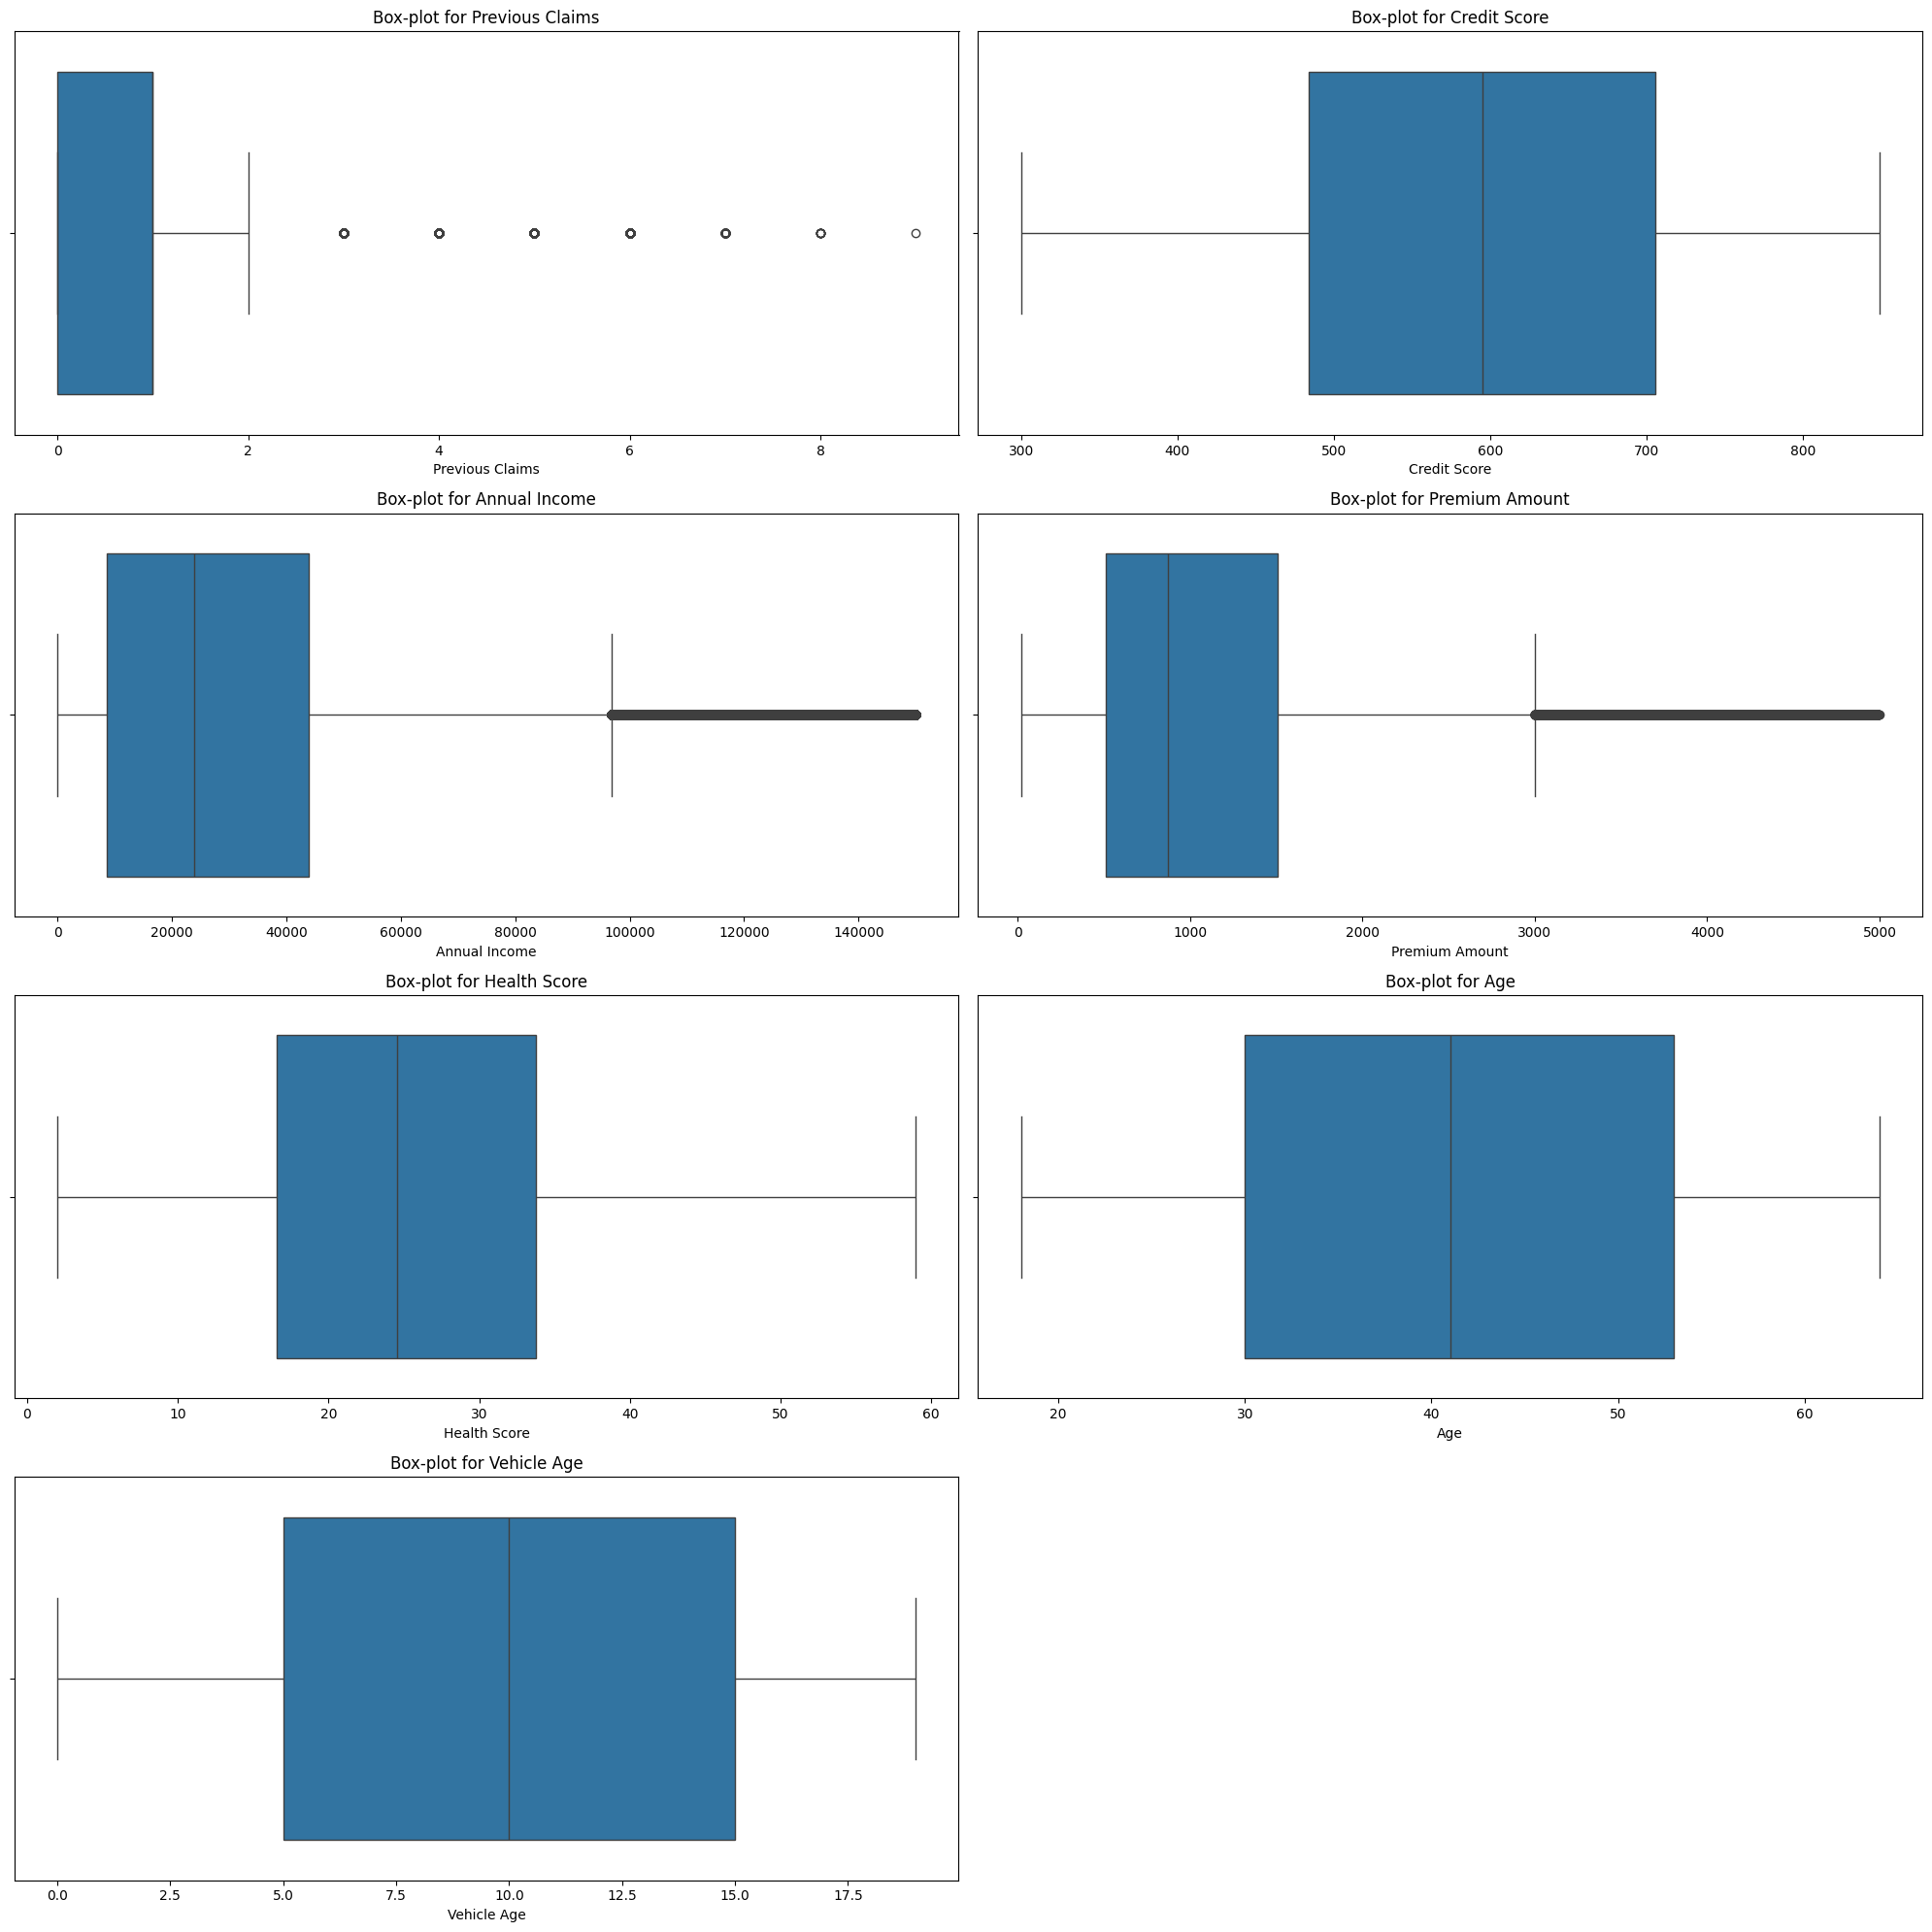

In [50]:
# Plotting the box plots
n_cols=2 # I always want to see only two columns
n_rows=((len(rqd_num_col)+1)//n_cols)
fig,axes=plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(20,20))
axes=axes.flatten()

# Plotting the box plots
for col_no,each_col in enumerate(rqd_num_col):
  sns.boxplot(data=df_train,x=each_col,ax=axes[col_no])
  axes[col_no].set_title(f'Box-plot for {each_col}')

# Deleting unnecessary axes
for del_plot in range(col_no+1,len(axes)):
  fig.delaxes(ax=axes[del_plot])

# Adjusting the visualization of the graphs
plt.tight_layout()
plt.show()


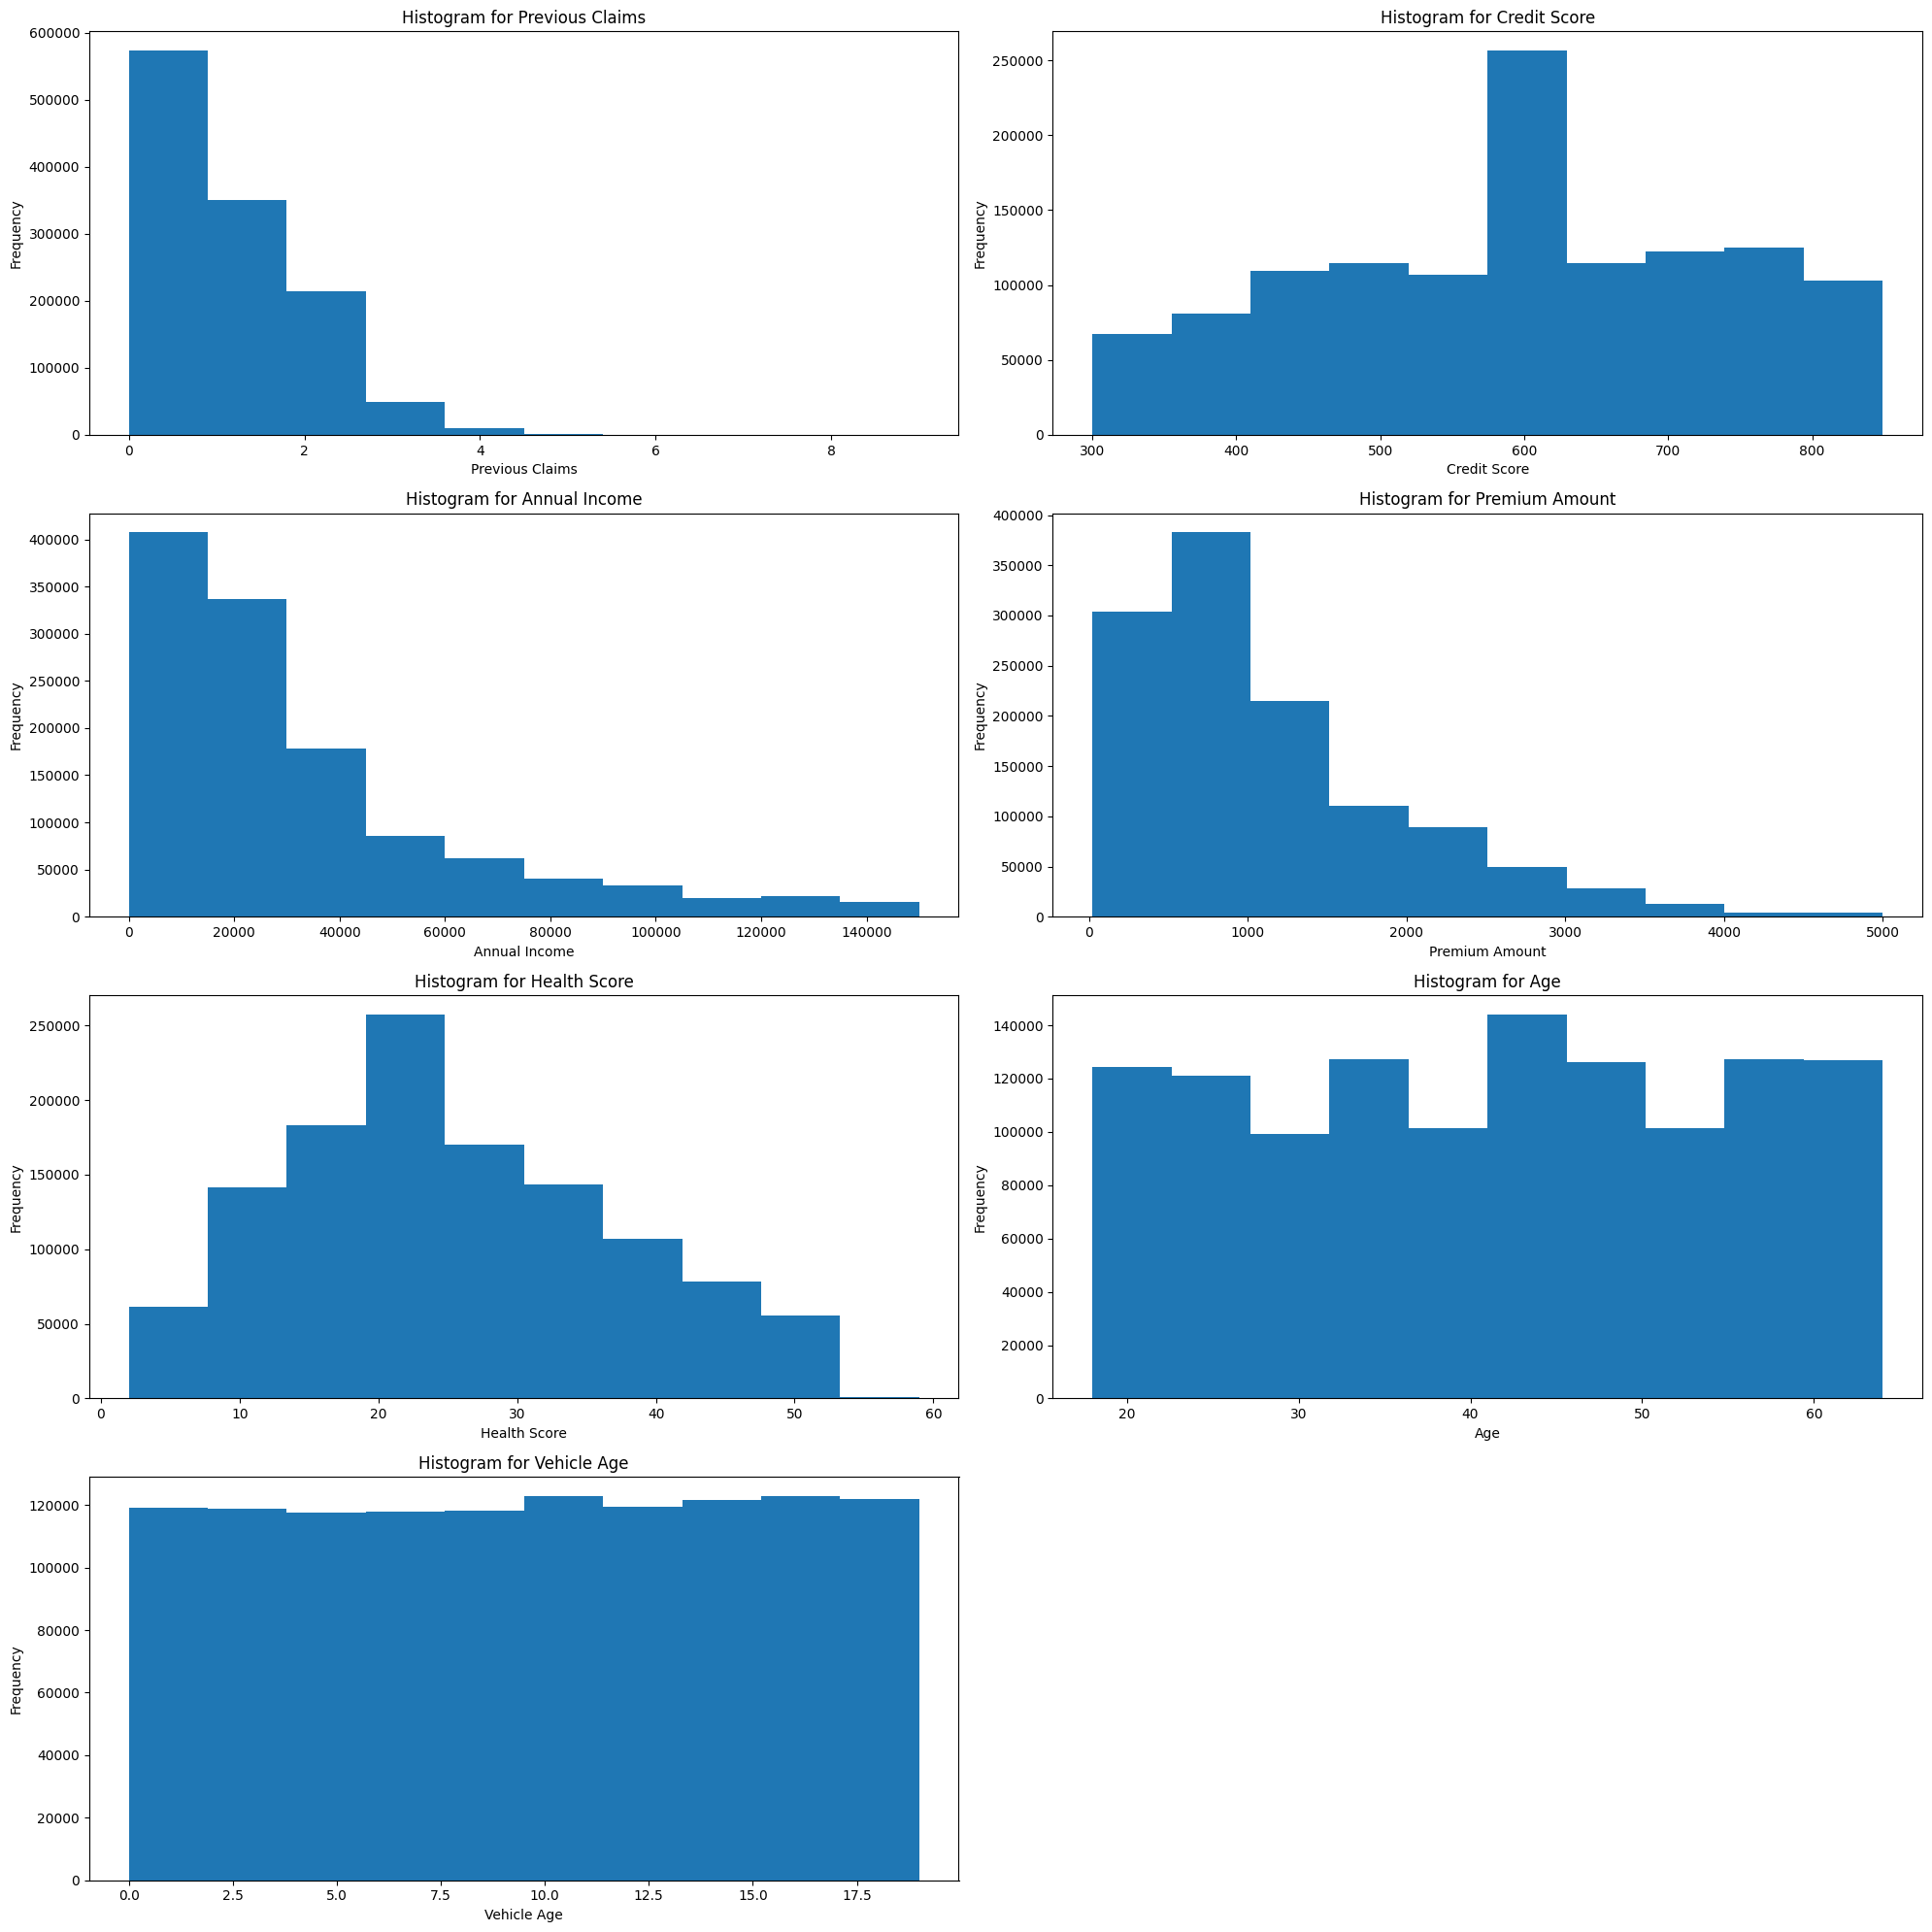

In [51]:
# Plotting the histograms of the numeric features to understand their distribution
n_cols=2
n_rows=((len(rqd_num_col)+1)//n_cols)
fig,axes=plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(20,20))
axes=axes.flatten()

# Plotting the histograms for the numeric columns
for col_no,each_col in enumerate(rqd_num_col):
  ax=axes[col_no]
  ax.hist(df_train[each_col])
  ax.set_title(f'Histogram for {each_col}')
  ax.set_xlabel(f'{each_col}')
  ax.set_ylabel('Frequency')

# Deleting the unnncessary axes
for axes_to_del in range(col_no+1,len(axes)):
  fig.delaxes(ax=axes[axes_to_del])

# Making the adjustments for plotting the histograms effectively
plt.tight_layout()
plt.show()

In [52]:
# Extracting the columns which are object
object_columns=list(df_train.select_dtypes(include='object').columns)

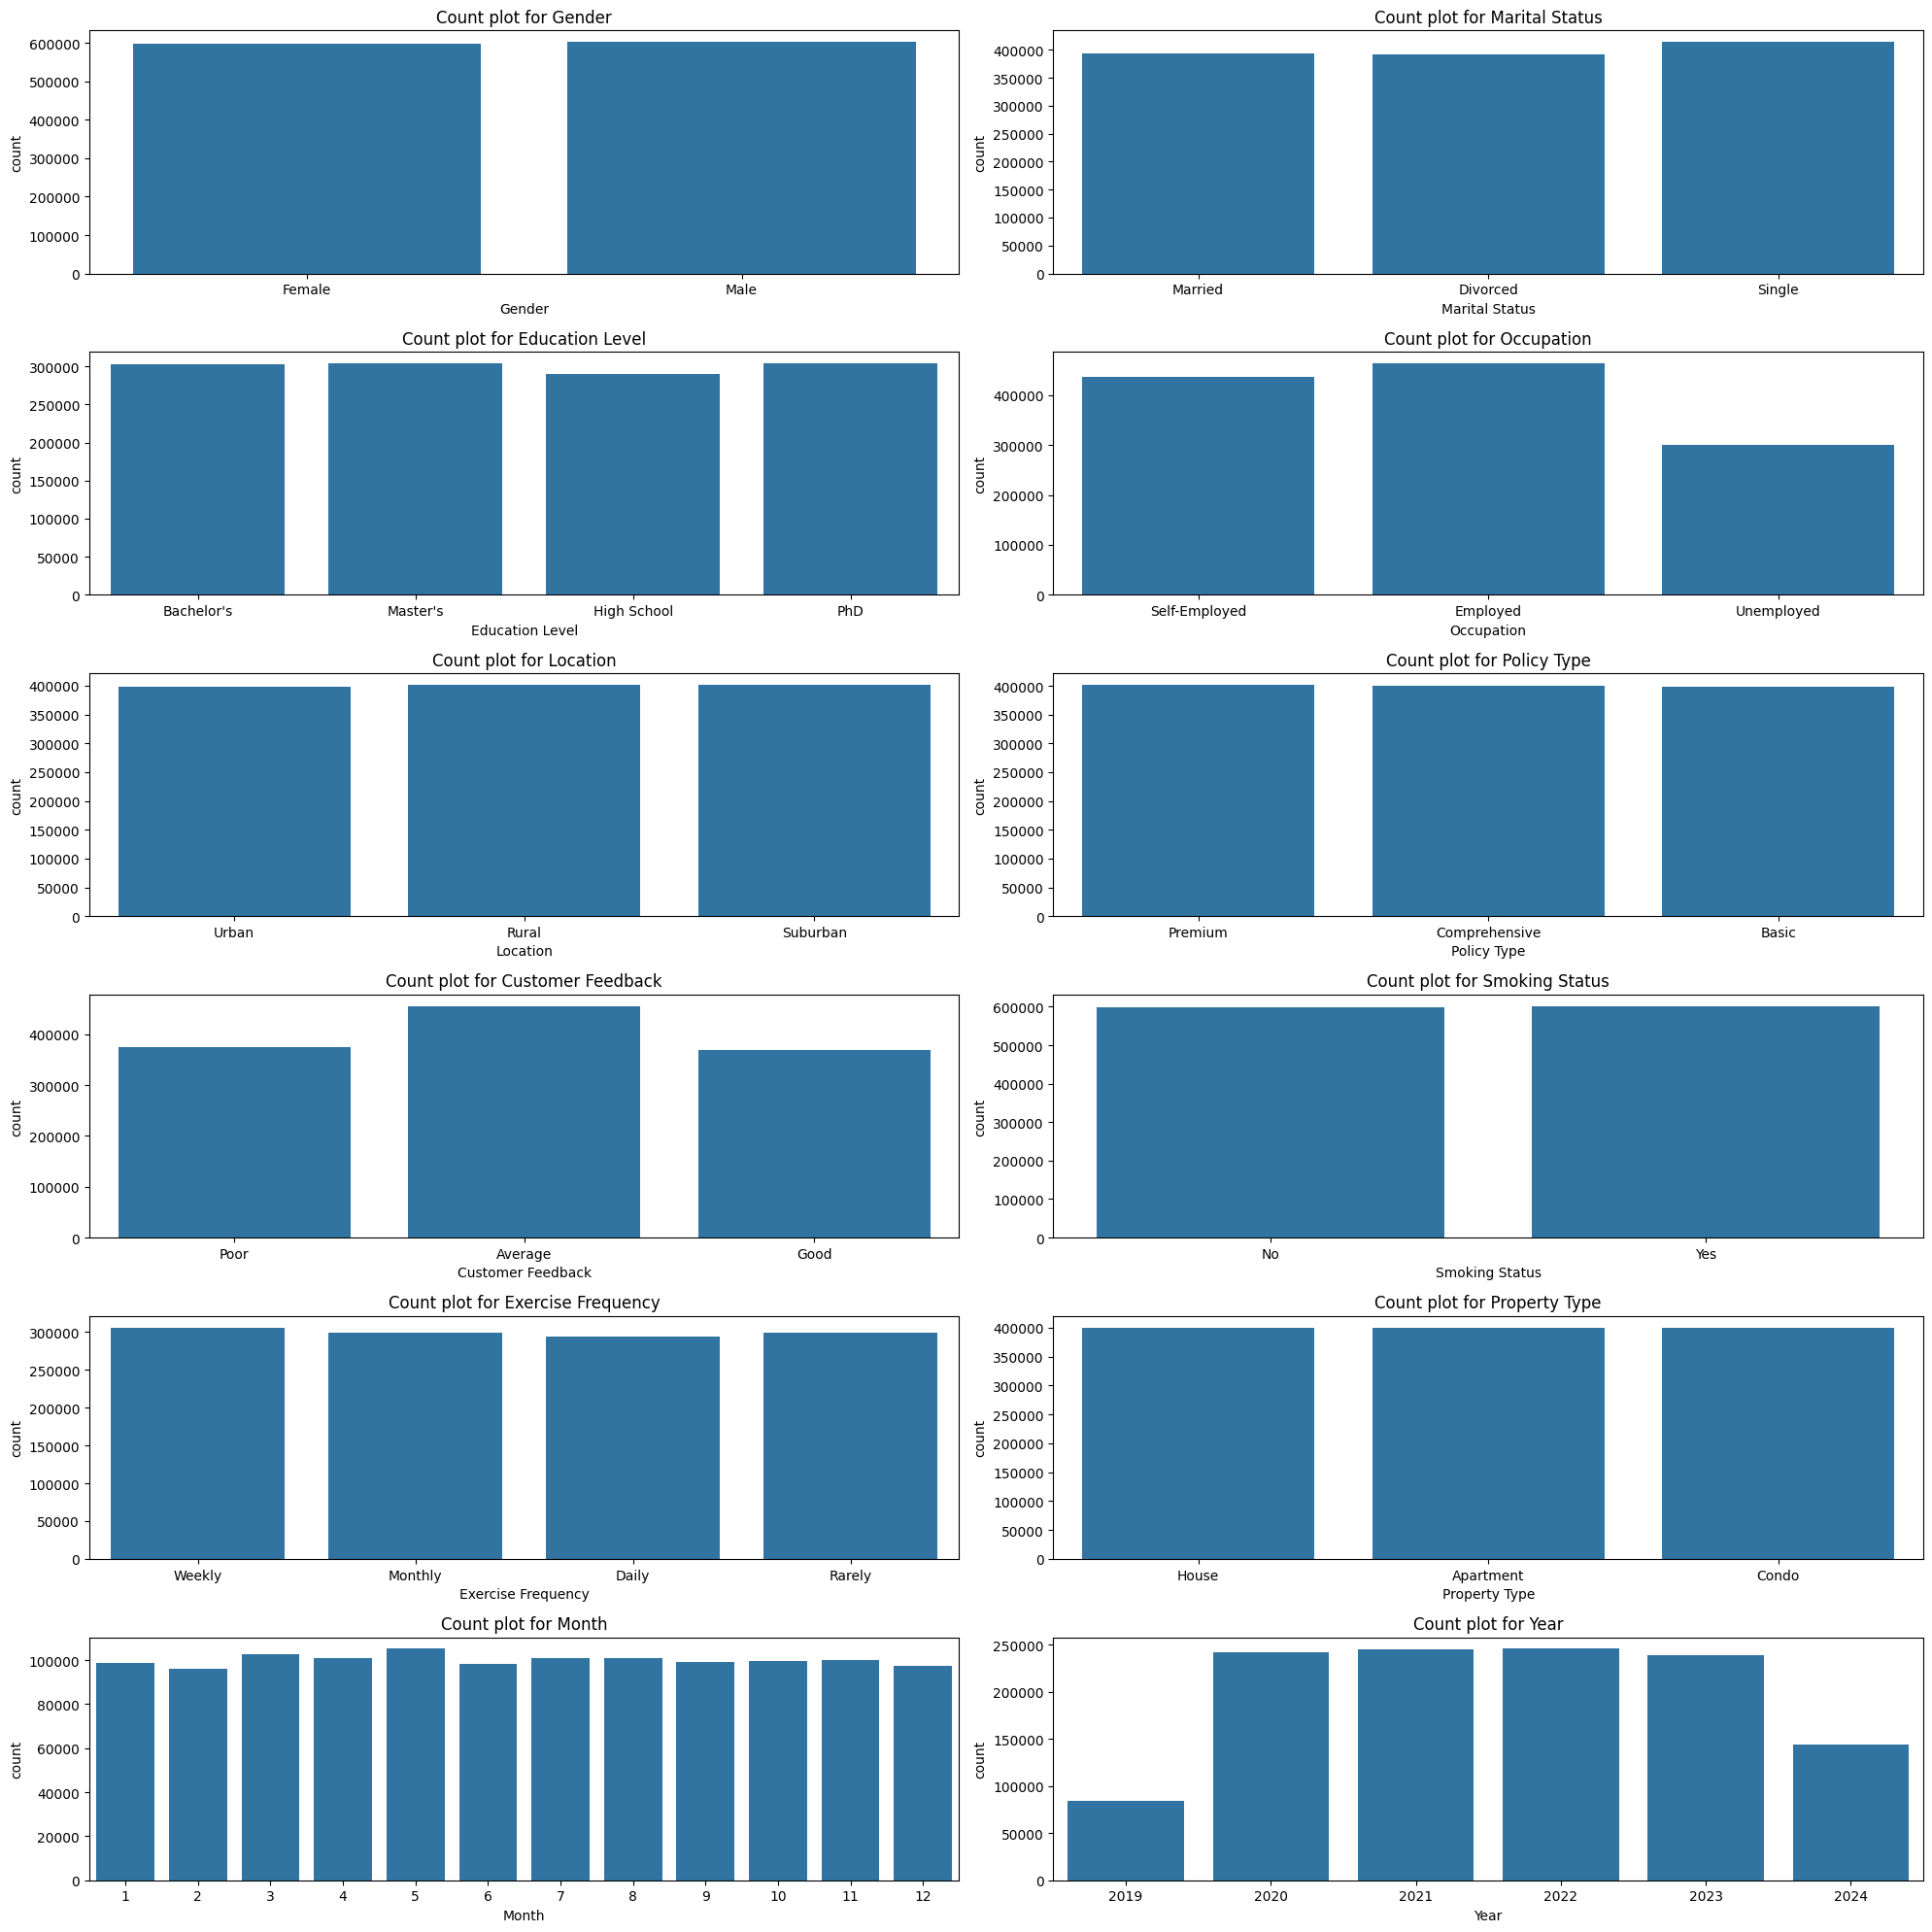

In [53]:
# plotting the countplots of the object columns 
n_cols=2
n_rows=((len(object_columns)+1)//n_cols)
fig,axes=plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(20,20))
axes=axes.flatten()

# plotting the countplots
for col_no,each_col in enumerate(object_columns):
  sns.countplot(data=df_train,x=each_col,ax=axes[col_no])
  axes[col_no].set_title(f'Count plot for {each_col}')

# Deleting unnecessary axes
for axes_to_del in range(col_no+1,len(axes)):
  fig.delaxes(ax=axes[axes_to_del])

# Arranging the layout as per the need
plt.tight_layout()
plt.show()

In [54]:
# Checking the basic info about df_train once again
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1200000 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1200000 non-null  float64
 3   Marital Status        1200000 non-null  object 
 4   Number of Dependents  1200000 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            1200000 non-null  object 
 7   Health Score          1200000 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       1200000 non-null  int64  
 11  Vehicle Age           1200000 non-null  float64
 12  Credit Score          1200000 non-null  float64
 13  Insurance Duration    1200000 non-null  float64
 14  Customer Feedback     1200000 non-

In [55]:
# Making a dummy dataframe from the object columns
df_dummies=pd.get_dummies(data=df_train,columns=object_columns,drop_first=True)

# Changing the boolean columns into 1/0 for correlation matrix creation
bool_col=df_dummies.select_dtypes(include='bool').columns
df_dummies[bool_col]=df_dummies[bool_col].astype(int)

# Making the premium amount as the first column for easier visualization & inference creation
dummy_columns=['Premium Amount']+[col for col in df_dummies.columns if col!='Premium Amount']
df_dummies=df_dummies[dummy_columns]

In [56]:
# Creating a correlation matrix
corr_mat=df_dummies.corr()

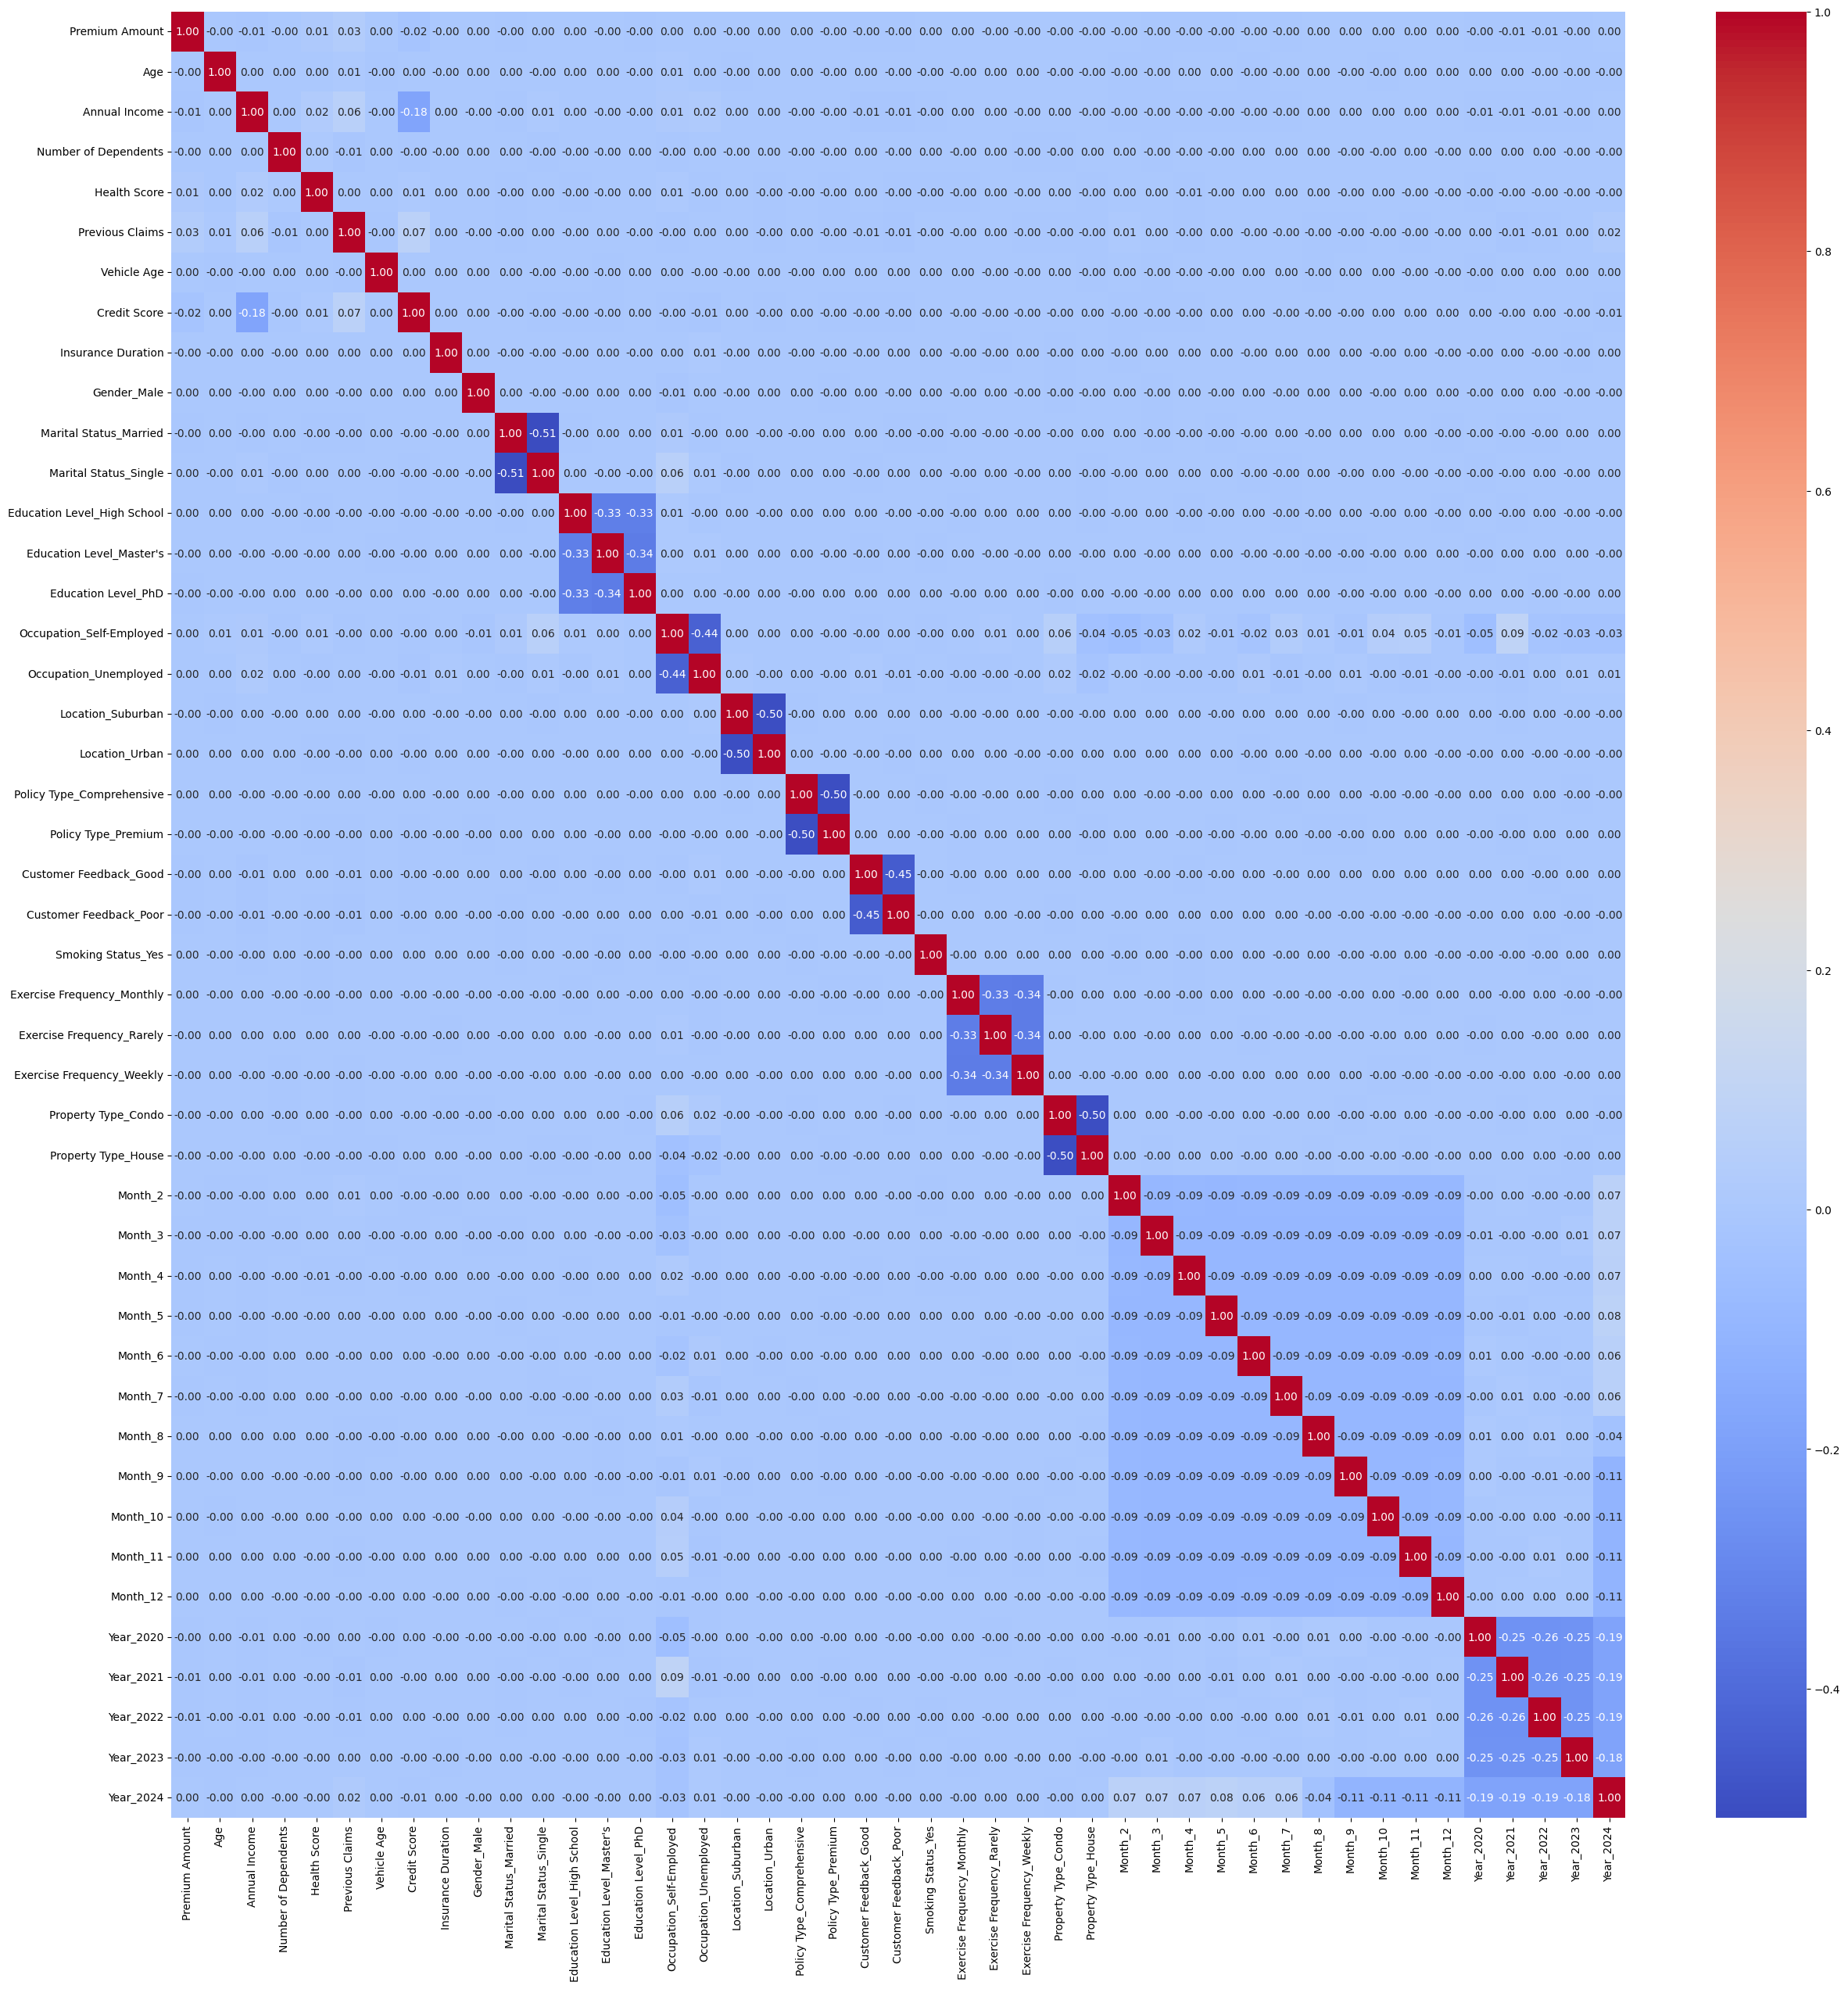

In [57]:
# Create a heat map
plt.figure(figsize=(30,30))
sns.heatmap(data=corr_mat,cmap='coolwarm',annot=True,fmt='.2f')
plt.show()

In [58]:
# I decided to check the basic info of the all columns in the df_dummies --> I decided to drop the dummy columns i.e.columns with datatype = int 32
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 45 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Premium Amount               1200000 non-null  float64
 1   Age                          1200000 non-null  float64
 2   Annual Income                1200000 non-null  float64
 3   Number of Dependents         1200000 non-null  float64
 4   Health Score                 1200000 non-null  float64
 5   Previous Claims              1200000 non-null  int64  
 6   Vehicle Age                  1200000 non-null  float64
 7   Credit Score                 1200000 non-null  float64
 8   Insurance Duration           1200000 non-null  float64
 9   Gender_Male                  1200000 non-null  int32  
 10  Marital Status_Married       1200000 non-null  int32  
 11  Marital Status_Single        1200000 non-null  int32  
 12  Education Level_High School  1200000 non-n

In [59]:
# Getting all the columns from the df_dummies which are not int32
col_int_32=df_dummies.select_dtypes(include='int32')
col_not_int_32=[col for col in df_dummies.columns if col not in col_int_32]

In [60]:
# Making a correlation matrix of the columns which are not obtained by making dummies
corr_mat_reduced=df_dummies[col_not_int_32].corr()

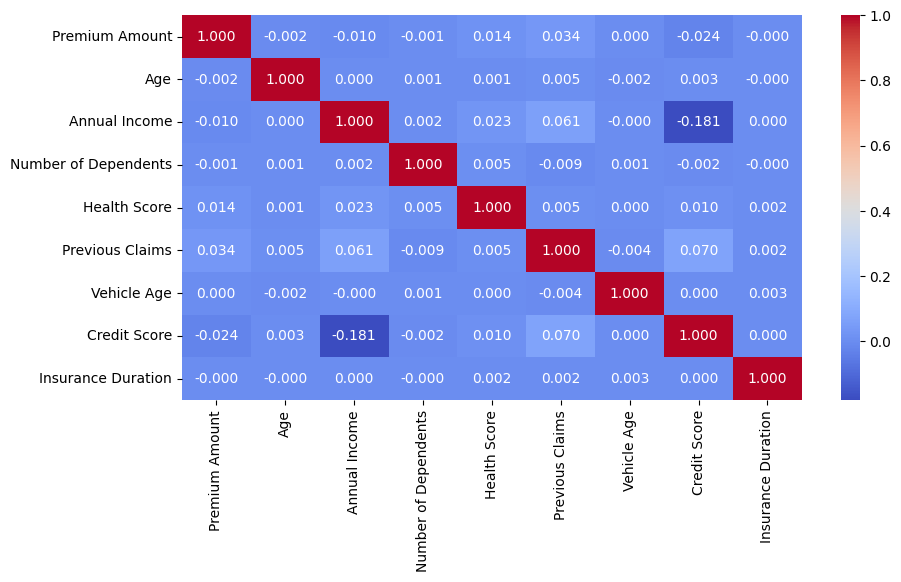

In [61]:
# Plotting the simplified heatmap 
plt.figure(figsize=(10,5))
sns.heatmap(data=corr_mat_reduced,cmap='coolwarm',annot=True,fmt='.3f')
plt.show()